# Experiment

TODO Explanation

In [1]:
# Install all required packages
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import GmGM
import warnings
import seaborn as sns

plt.style.use('tableau-colorblind10')

We'll use this dataset:
    [Spatio-temporal immune zonation of the human kidney](https://www.ebi.ac.uk/gxa/sc/experiments/E-HCAD-10/results/tsne)

It has ~30,000 cells, which is about as large as we can reasonably expect people to be able to download during a workshop.  Downloading it will take a few minutes, but once its downloaded it will 

In [3]:
# This establishes the directory that the data will be saved to
sc._settings.ScanpyConfig.datasetdir = Path('../data/')
adata = sc.datasets.ebi_expression_atlas(
    accession='E-HCAD-10',
)
adata

AnnData object with n_obs × n_vars = 31711 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individu

The gene names are stored as ENSG codes, so let's get the external gene names as well!

In [4]:
mapping = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "external_gene_name"]
)
mapping = mapping.set_index("ensembl_gene_id")
mapping = mapping[mapping.index.isin(adata.var_names)]

# Add to adata
adata.var["external_gene_name"] = "Not in Biomart"
adata.var.loc[adata.var_names.isin(mapping.index), "external_gene_name"] = mapping["external_gene_name"]
adata.var[adata.var["external_gene_name"].isna()] = "Biomart NaN"

In [5]:
adata.var["external_gene_name"]

ENSG00000000003                     TSPAN6
ENSG00000000005                       TNMD
ENSG00000000419                       DPM1
ENSG00000000457                      SCYL3
ENSG00000000460                      FIRRM
                            ...           
ENSG00000289695                Biomart NaN
ENSG00000289697                Biomart NaN
ENSG00000289700                Biomart NaN
ENSG00000289701                Biomart NaN
ENSG00000289716    XNDC1N-ZNF705EP-ALG1L9P
Name: external_gene_name, Length: 26385, dtype: object

In [6]:
adata.obs['inferred cell type'] = adata.obs['Factor Value[inferred cell type - authors labels]'].cat.add_categories("unknown").fillna("unknown")
adata.obs['inferred cell type']

4834STDY7002875_S1_L001-AAAATGAAGCCAGTAG                      unknown
4834STDY7002875_S1_L001-AAACCAATCTTCGGTC                      unknown
4834STDY7002875_S1_L001-AAACCTATCAACACAC                      unknown
4834STDY7002875_S1_L001-AAACCTATCAGAAATG                      unknown
4834STDY7002875_S1_L001-AAACCTCAGGAGCGAG                      unknown
                                                      ...            
FCAImmP7579215_S1_L001-TTTGTCAAGATATGGT     distal renal vesicle cell
FCAImmP7579215_S1_L001-TTTGTCAAGGAGTCTG                       unknown
FCAImmP7579215_S1_L001-TTTGTCACACAGCGTC           cap mesenchyme cell
FCAImmP7579215_S1_L001-TTTGTCACATTAACCG             fibroblast type 1
FCAImmP7579215_S1_L001-TTTGTCATCATGTCTT             stroma progenitor
Name: inferred cell type, Length: 31711, dtype: category
Categories (45, object): ['B cell', 'CD4+ T cell', 'CD8+ T cell', 'cap mesenchyme cell', ..., 'proximal renal vesicle cell', 'proximal ureteric bud cell', 'stroma progenitor

# Preprocessing

Here we will do some simple preprocessing of the data.  The goal will be to remove low-quality cells and genes; we will also log-transform the data.

For this we can rely on the `scanpy` library, which fills the niche in Python that Seurat does in R.

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

AnnData object with n_obs × n_vars = 31711 × 26385
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individu

In [8]:
# Quality Control Cutoffs
# feel free to change! they are fairly arbitrary

# Keep cells who are expressed in at least __ genes
n_genes_by_counts_cutoff = 1000

# Keep cells who have a total expression of ___ when summed across all genes
cells_total_counts_cutoff = 10_000

# Keep genes who are expressed in at least __ cells
n_cells_by_counts_cutoff = 1000

# Keep cells who have a total expression of ___ when summed across all cells
genes_total_counts_cutoff = 50_000

8884 cells kept (28.02%)
687 genes kept (2.17%)


View of AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[ind

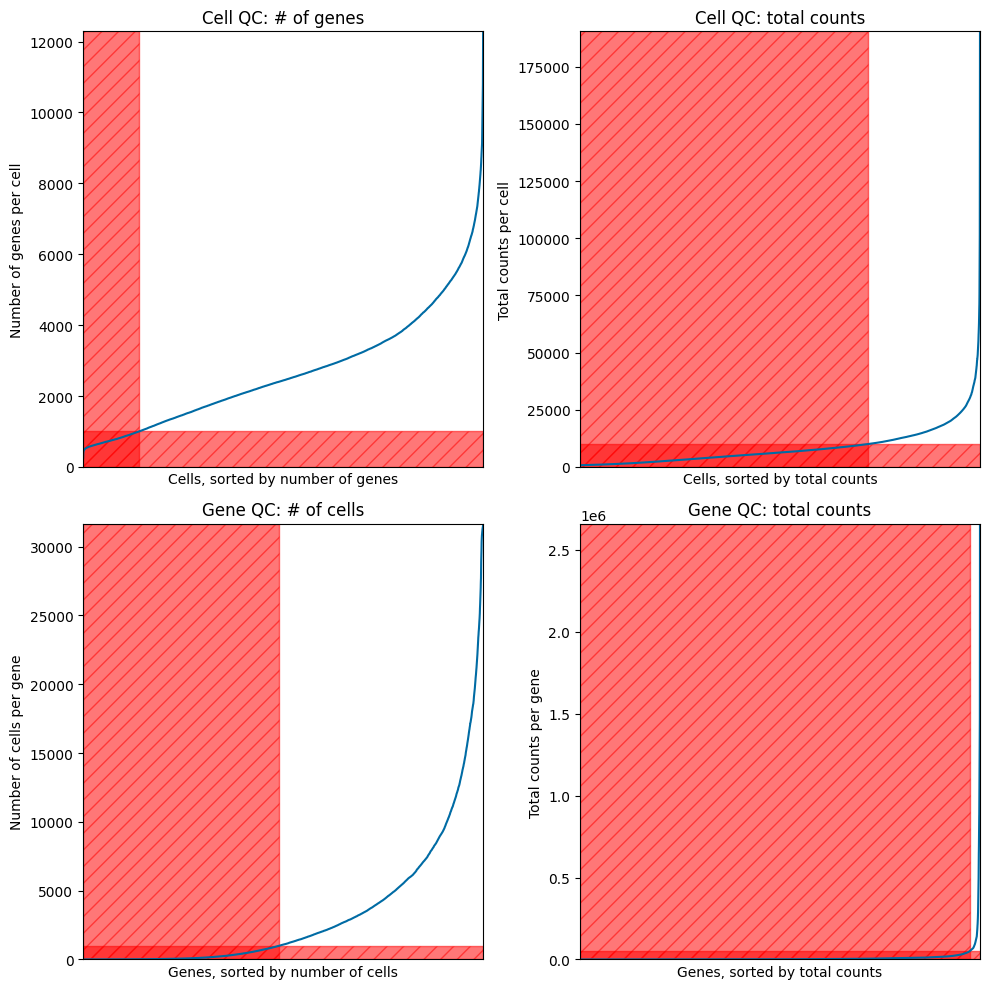

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axs.flatten()

# Number of genes
adata.obs['n_genes_by_counts'].sort_values().plot(ax=ax1)
ax1.set_xticks([])
ax1.set_ylabel("Number of genes per cell")
ax1.set_xlabel("Cells, sorted by number of genes")
ax1.set_title("Cell QC: # of genes")
ax1.set_ylim(0, adata.obs['n_genes_by_counts'].max())
ax1.set_xlim(0, adata.obs['n_genes_by_counts'].shape[0])
ax1.axhspan(0, n_genes_by_counts_cutoff, color="#FF000088", hatch='//')
cells_keep_1 = ~(adata.obs['n_genes_by_counts'] < n_genes_by_counts_cutoff)
ax1.axvspan(0, (~cells_keep_1).sum(), color="#FF000088", hatch='//')

# Total counts of genes
adata.obs['total_counts'].sort_values().plot(ax=ax2)
ax2.set_xticks([])
ax2.set_ylabel("Total counts per cell")
ax2.set_xlabel("Cells, sorted by total counts")
ax2.set_title("Cell QC: total counts")
ax2.set_ylim(0, adata.obs['total_counts'].max())
ax2.set_xlim(0, adata.obs['total_counts'].shape[0])
ax2.axhspan(0, cells_total_counts_cutoff, color="#FF000088", hatch='//')
cells_keep_2 = ~(adata.obs['total_counts'] < cells_total_counts_cutoff)
ax2.axvspan(0, (~cells_keep_2).sum(), color="#FF000088", hatch='//')

# Number of cells
adata.var['n_cells_by_counts'].sort_values().plot(ax=ax3)
ax3.set_xticks([])
ax3.set_ylabel("Number of cells per gene")
ax3.set_xlabel("Genes, sorted by number of cells")
ax3.set_title("Gene QC: # of cells")
ax3.set_ylim(0, adata.var['n_cells_by_counts'].max())
ax3.set_xlim(0, adata.var['n_cells_by_counts'].shape[0])
ax3.axhspan(0, n_cells_by_counts_cutoff, color="#FF000088", hatch='//')
genes_keep_1 = ~(adata.var['n_cells_by_counts'] < n_cells_by_counts_cutoff)
ax3.axvspan(0, (~genes_keep_1).sum(), color="#FF000088", hatch='//')

# Total counts of cells
adata.var['total_counts'].sort_values().plot(ax=ax4)
ax4.set_xticks([])
ax4.set_ylabel("Total counts per gene")
ax4.set_xlabel("Genes, sorted by total counts")
ax4.set_title("Gene QC: total counts")
ax4.set_ylim(0, adata.var['total_counts'].max())
ax4.set_xlim(0, adata.var['total_counts'].shape[0])
ax4.axhspan(0, genes_total_counts_cutoff, color="#FF000088", hatch='//')
genes_keep_2 = ~(adata.var['total_counts'] < genes_total_counts_cutoff)
ax4.axvspan(0, (~genes_keep_2).sum(), color="#FF000088", hatch='//')

fig.tight_layout()

cells_keep = cells_keep_1 & cells_keep_2
genes_keep = genes_keep_1 & genes_keep_2
print(f"{cells_keep.sum()} cells kept ({cells_keep.sum()/adata.shape[0]:.2%})")
print(f"{genes_keep.sum()} genes kept ({genes_keep.sum()/adata.shape[0]:.2%})")

# Filter the adata
fadata = adata[cells_keep, genes_keep]
fadata

In [10]:
# Log transform (in place)
sc.pp.log1p(adata)
sc.pp.log1p(fadata)
fadata

/home/codespace/.python/current/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:401: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual]

# Visualization

In [11]:
# Parameters (feel free to change these)
N_COMPS = 50
N_NEIGHBORS = 10

Text(0.5, 1.0, 'Explained variance of filtered dataset (cells)')

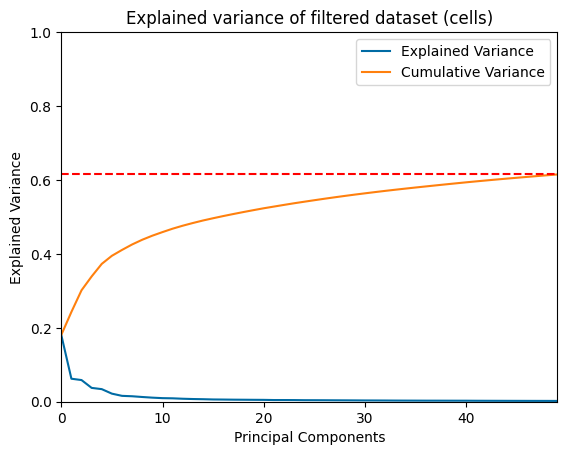

In [12]:
sc.pp.pca(fadata, n_comps=N_COMPS)

fig, ax = plt.subplots()
explained_variance = fadata.uns['pca']['variance_ratio']
ax.plot(explained_variance, label="Explained Variance")
ax.plot(explained_variance.cumsum(), label="Cumulative Variance")

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_xlim(0, N_COMPS - 1)
ax.set_ylim(0, 1)

ax.axhline(explained_variance.cumsum().max(), linestyle='--', color='red')
ax.legend()

ax.set_title("Explained variance of filtered dataset (cells)")

In [13]:
# Should take around a minute to run
sc.pp.neighbors(fadata, n_neighbors=N_NEIGHBORS)
sc.tl.umap(fadata)

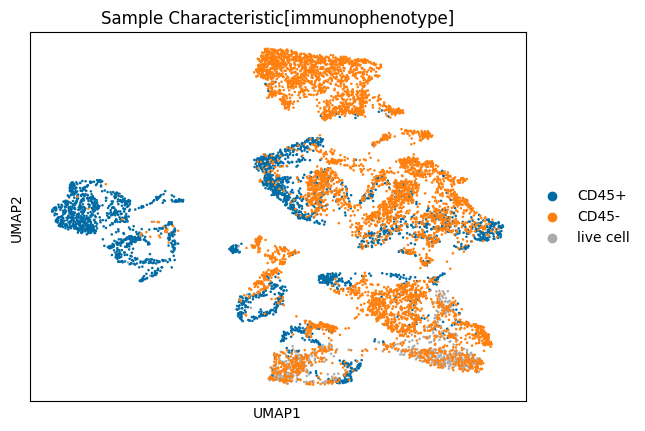

In [14]:
sc.pl.umap(fadata, color=['Sample Characteristic[immunophenotype]'])

In [15]:
# Let's look at the genes now!
fbdata = fadata.transpose()

Text(0.5, 1.0, 'Explained variance of filtered dataset (genes)')

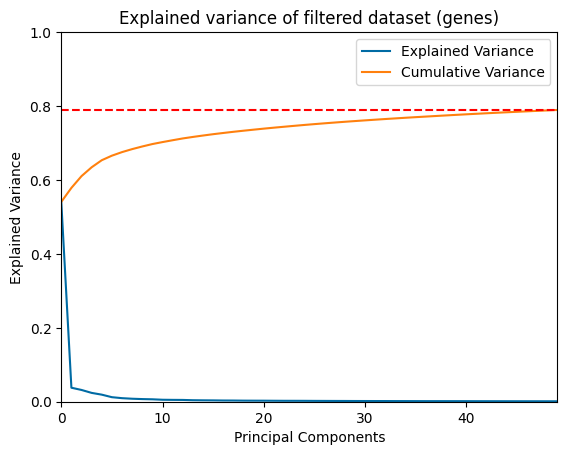

In [16]:
sc.pp.pca(fbdata, n_comps=N_COMPS)

fig, ax = plt.subplots()
explained_variance = fbdata.uns['pca']['variance_ratio']
ax.plot(explained_variance, label="Explained Variance")
ax.plot(explained_variance.cumsum(), label="Cumulative Variance")

ax.set_xlabel("Principal Components")
ax.set_ylabel("Explained Variance")

ax.set_xlim(0, N_COMPS - 1)
ax.set_ylim(0, 1)

ax.axhline(explained_variance.cumsum().max(), linestyle='--', color='red')
ax.legend()

ax.set_title("Explained variance of filtered dataset (genes)")

In [17]:
# Should be very quick to run
sc.pp.neighbors(fbdata, n_neighbors=N_NEIGHBORS)
sc.tl.umap(fbdata)

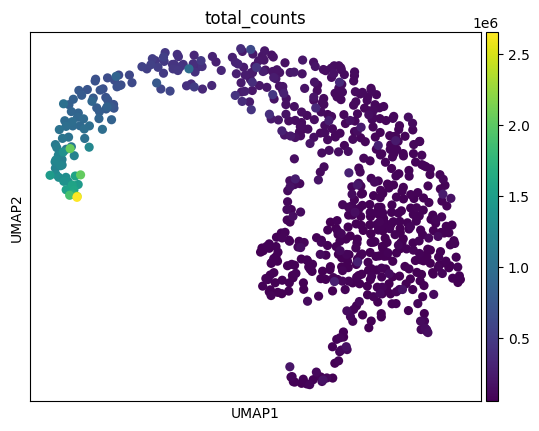

In [18]:
sc.pl.umap(fbdata, color=['total_counts'])

# Graphical Models

## GmGM

In [19]:
# Note that GmGM natively accepts AnnData and MuData, i.e. we could pass
# fadata into the algorithm directly, rather than wrapping it
# in `GmGM.Dataset`.  However more general datastructures need to be wrapped,
# so in this tutorial we will use the most general way

dataset = GmGM.Dataset(
    dataset={"data": fadata.X},
    structure={"data": ("cell", "gene")}
)

output = GmGM.GmGM(
    dataset,
    to_keep=N_NEIGHBORS, # how many edges per cell (on average) should we keep
    threshold_method="overall-col-weighted", # method of keeping top genes
    min_edges={"cell": 5, "gene": 3}, # to ensure the graphs have no singletons
    n_comps=N_COMPS, # number of principal components to use
    centering_method=None,
    use_nonparanormal_skeptic=True, # account for non-Gaussian marginals
    nonparanormal_evec_backend='COCA',
    calculate_explained_variance=True,
    batch_size=1000, # making this smaller for very large datasets may save memory
    verbose=True,
)

/home/codespace/.python/current/lib/python3.10/site-packages/GmGM/dataset.py:167: UserWarning: Trying to set data's tensor of type <class 'scipy.sparse._csr.csr_matrix'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(


Centering...
Calculating eigenvectors...
	by calculating left eigenvectors and applying a rank-one update...
		Computing sparse normal map for axis='cell'...
		...Done computing sparse normal map
		Explained variance for axis='cell': 66.5551%
		Computing sparse normal map for axis='gene'...
		...Done computing sparse normal map
		Explained variance for axis='gene': 81.7529%
Calculating eigenvalues...
@0: 7373066.09017819 (-1777.9948359319503 + 7374844.085014122 + 0) ∆inf
Converged! (@17: 4330048.1159756845)
Recomposing sparse precisions...
Done!


In [20]:
# Now add the results to our AnnData objects
fadata.obsp['cell_gmgm'] = output.precision_matrices['cell']
fadata.varp['gene_gmgm'] = output.precision_matrices['gene']

fbdata.varp['cell_gmgm'] = output.precision_matrices['cell']
fbdata.obsp['gene_gmgm'] = output.precision_matrices['gene']

# Also add it to dataset that has all genes, so that we can
# later look at gene expression of out-filtered genes!
gadata = adata[cells_keep]
gadata.obsp['cell_gmgm'] = output.precision_matrices['cell']
gadata.obsm['X_umap'] = fadata.obsm['X_umap']

/tmp/ipykernel_23152/1703239991.py:11: ImplicitModificationWarning: Setting element `.obsp['cell_gmgm']` of view, initializing view as actual.
  gadata.obsp['cell_gmgm'] = output.precision_matrices['cell']


## Graphical Lasso

In [21]:
# TODO: this; save under 'cell_glasso' and 'gene_glasso'

# Evaluate Results

In [22]:
# Run Leiden clustering
sc.tl.leiden(fadata, obsp='cell_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(gadata, obsp='cell_gmgm', key_added='leiden_gmgm')
sc.tl.leiden(fbdata, obsp='gene_gmgm', key_added='leiden_gmgm')
fadata

/tmp/ipykernel_23152/3018595570.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(fadata, obsp='cell_gmgm', key_added='leiden_gmgm')


AnnData object with n_obs × n_vars = 8884 × 687
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[gestational age]', 'Sample Characteristic Ontology Term[gestational age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[immunophenotype]', 'Sample Characteristic Ontology Term[immunophenotype]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Factor Value[individual]

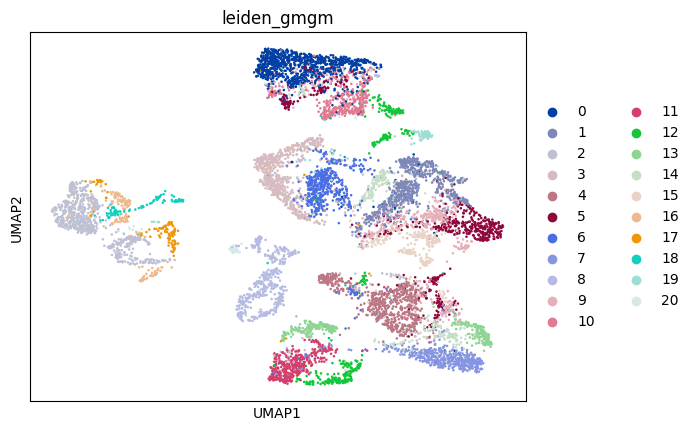

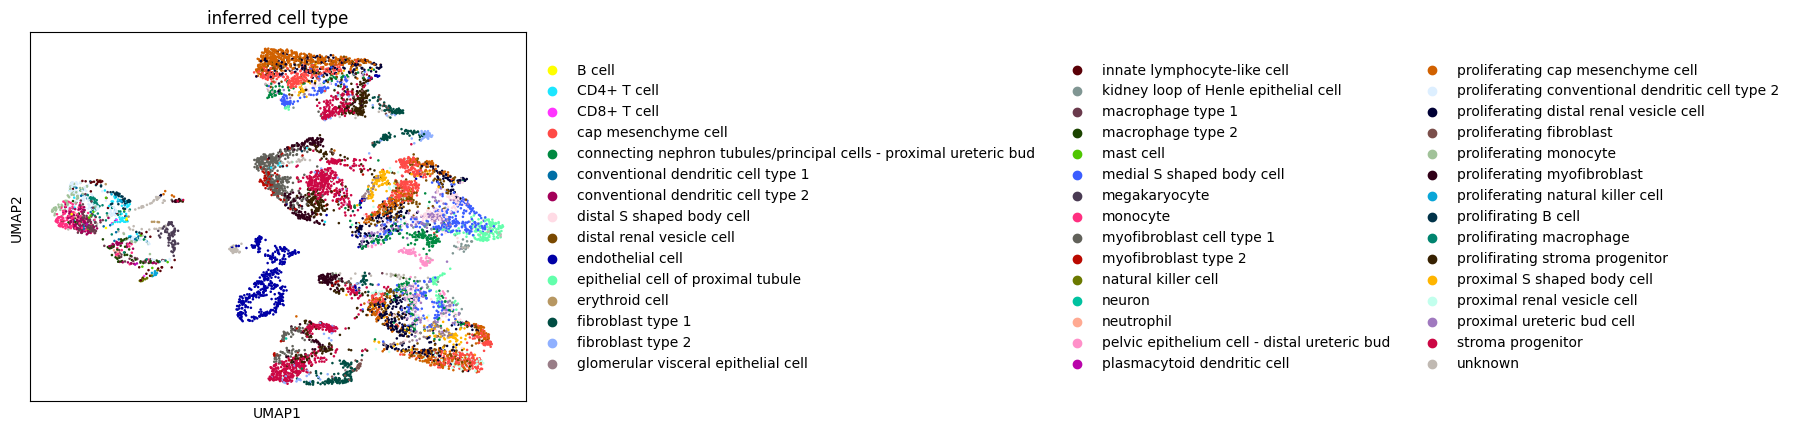

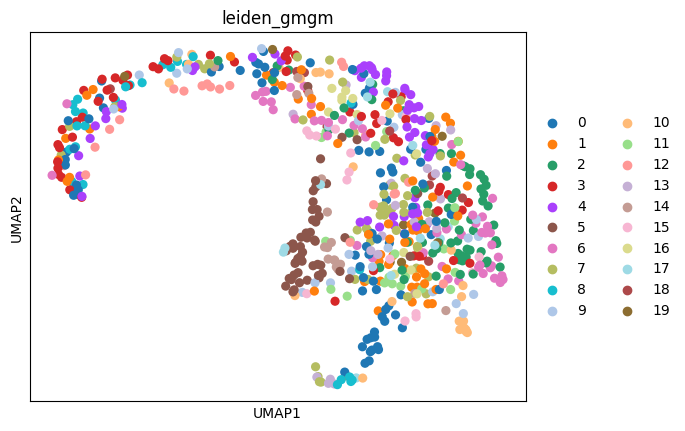

In [23]:
sc.pl.umap(gadata, color=['leiden_gmgm'])
sc.pl.umap(gadata, color=['inferred cell type'])
sc.pl.umap(fbdata, color=['leiden_gmgm'])

In [24]:
def jaccard(x: set, y: set) -> float:
    return len(x & y) / len(x | y)

def dice(x: set, y: set) -> float:
    return 2 * len(x & y) / (len(x) + len(y))

def overlap(x: set, y: set) -> float:
    return len(x & y) / min(len(x), len(y))

def get_overlap(x: set, y: set, OVERLAP_METHOD: str) -> float:
    if OVERLAP_METHOD == "overlap":
        return overlap(x, y)
    elif OVERLAP_METHOD == "dice":
        return dice(x, y)
    elif OVERLAP_METHOD == "jaccard":
        return jaccard(x, y)
    else:
        raise ValueError(f"Unknown method {OVERLAP_METHOD}")    

In [32]:
OVERLAP_METHOD = "overlap"

# Create confusion matrix
confusion = np.zeros((
    gadata.obs['leiden_gmgm'].nunique(),
    gadata.obs['inferred cell type'].nunique()
))

for my_cluster in gadata.obs['leiden_gmgm'].unique():
    i = int(my_cluster)
    for j, cell_type in enumerate(gadata.obs['inferred cell type'].unique()):
        confusion[i, j] = get_overlap(
            set(gadata[gadata.obs["leiden_gmgm"] == my_cluster].obs_names),
            set(gadata[gadata.obs['inferred cell type'] == cell_type].obs_names),
            OVERLAP_METHOD
        )

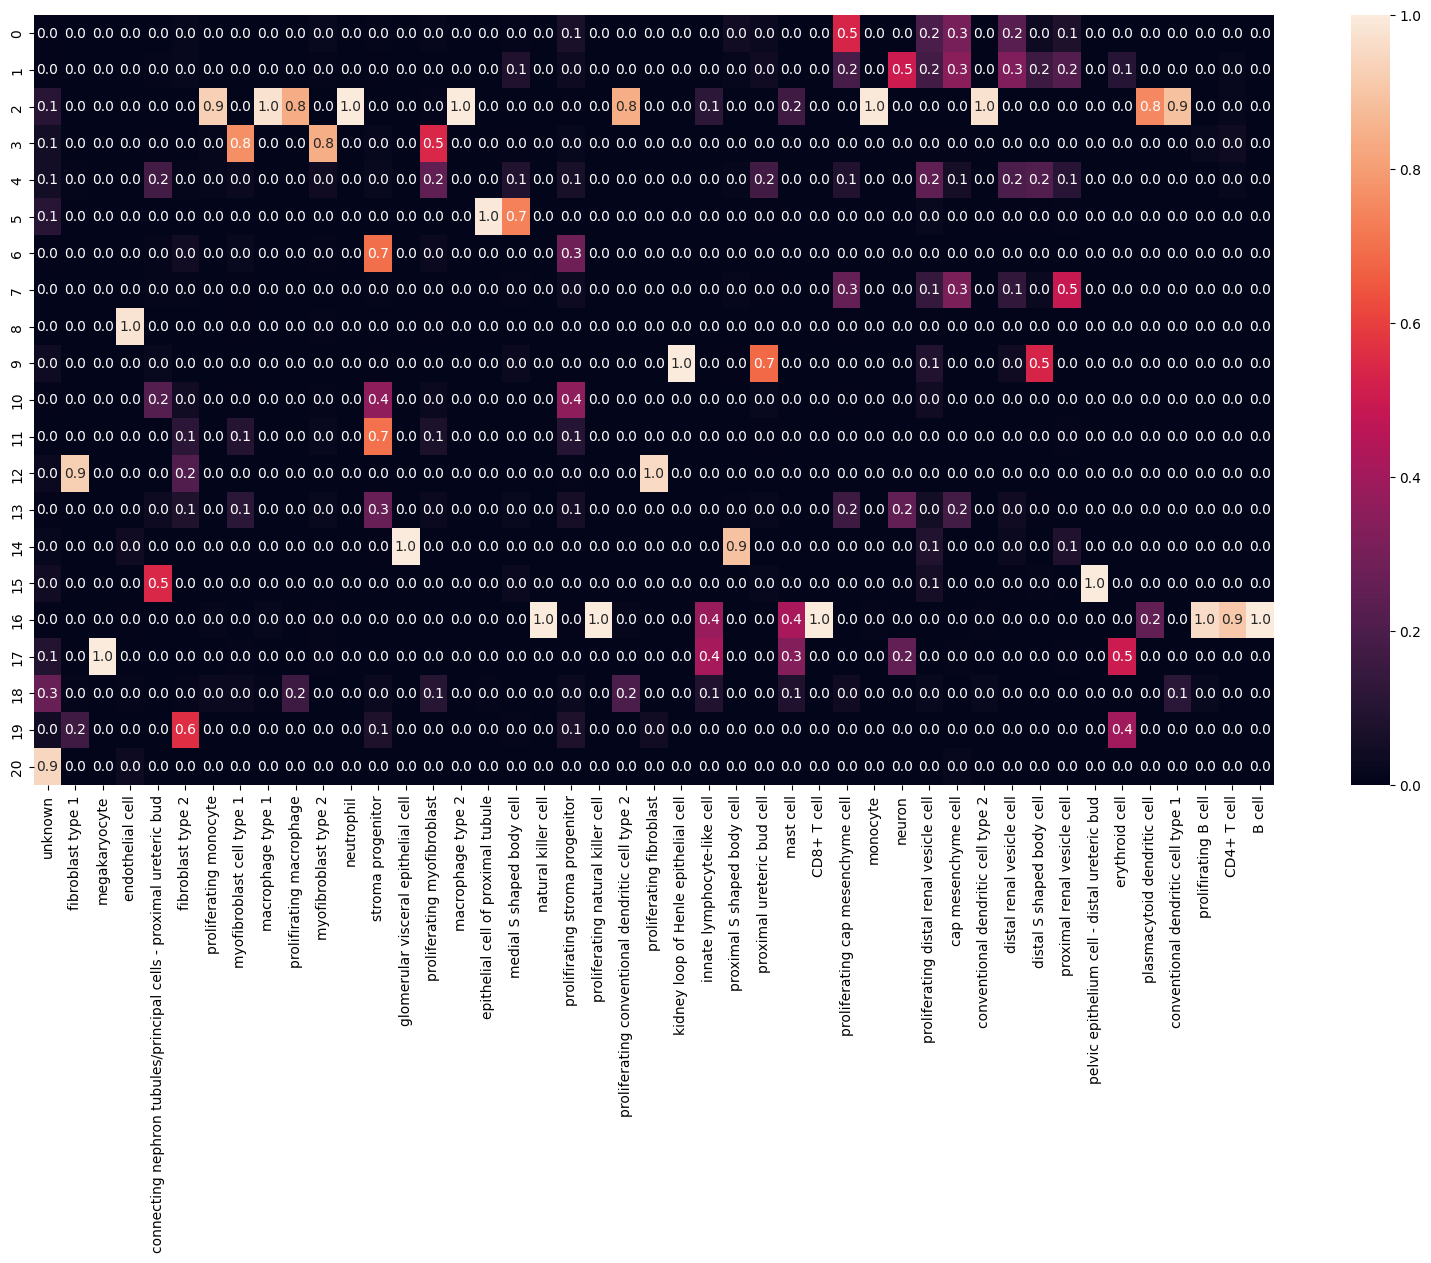

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))
xs = gadata.obs['inferred cell type'].unique()
ys = np.arange(gadata.obs['leiden_gmgm'].nunique())
sns.heatmap(confusion, annot=True, xticklabels=xs, yticklabels=ys, ax=ax, fmt=".1f")
plt.xticks(rotation=90)
pass